In [ ]:
import nltk
nltk.download(['vader_lexicon','punkt','stopwords'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize

import string as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
import pickle

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Factiva/eda01_integration/eda_data.csv')
df

,GVKEY,File,Document,Date,Time,Words,Data,num_word,new_data
0,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200417eg4h000es,17 April 2020,18:09,304 words,Standard Motor Products' Olivia Newton Named C...,304,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand..."
1,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200306eg36000ei,6 March 2020,20:21,328 words,"Standard Motor Products, Inc. Announces New St...",328,"NEW YORK, March 6, 2020 /PRNewswire/ -- Standa..."
2,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020210505eh55000gx,5 May 2021,13:30,"2,145 words","Standard Motor Products, Inc. Announces First ...",2145,"NEW YORK, May 5, 2021 /PRNewswire/ -- Standard..."
3,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020210225eh2p0008f,25 February 2021,12:30,370 words,"Standard Motor Products, Inc. Announces Public...",370,"NEW YORK, Feb. 25, 2021 /PRNewswire/ -- Standa..."
4,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200513eg5d0009c,13 May 2020,13:30,332 words,"Standard Motor Products, Inc. Announces a Chan...",332,"NEW YORK, May 13, 2020 /PRNewswire/ -- Standar..."
...,...,...,...,...,...,...,...,...,...
454207,9919,Factiva-20211126-0529.rtf,Document DJDN000020200723eg7n003dq,23 July 2020,19:37,721 words,Press Release: Utilimaster To Host Drive-Thru ...,721,Utilimaster To Host Drive-Thru Hiring Event In...
454208,9919,Factiva-20211126-0529.rtf,Document DJDN000020210423eh4n001jp,23 April 2021,09:13,687 words,"SHYFT GROUP INC COM, Inst Holders, 1Q 2021 (SH...",687,The following table shows the largest sharehol...
454209,9919,Factiva-20211126-0529.rtf,Document DJDN000020200521eg5l0038h,21 May 2020,21:49,210 words,"Spartan Motors Files 8K - Director, Officer or...",210,Spartan Motors Inc. (SPAR) filed a Form 8K - D...
454210,9919,Factiva-20211126-0529.rtf,Document DJDN000020200508eg58001tt,8 May 2020,13:00,774 words,Press Release: Spartan Motors Announces Semi-A...,774,Spartan Motors Announces Semi-Annual Dividend\...


In [ ]:
df['num_line'] = df.new_data.apply(lambda x : x.split('\n')).apply(len)
df.head()

,GVKEY,File,Document,Date,Time,Words,Data,num_word,new_data,num_line
0,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200417eg4h000es,17 April 2020,18:09,304 words,Standard Motor Products' Olivia Newton Named C...,304,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand...",10
1,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200306eg36000ei,6 March 2020,20:21,328 words,"Standard Motor Products, Inc. Announces New St...",328,"NEW YORK, March 6, 2020 /PRNewswire/ -- Standa...",8
2,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020210505eh55000gx,5 May 2021,13:30,"2,145 words","Standard Motor Products, Inc. Announces First ...",2145,"NEW YORK, May 5, 2021 /PRNewswire/ -- Standard...",225
3,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020210225eh2p0008f,25 February 2021,12:30,370 words,"Standard Motor Products, Inc. Announces Public...",370,"NEW YORK, Feb. 25, 2021 /PRNewswire/ -- Standa...",10
4,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200513eg5d0009c,13 May 2020,13:30,332 words,"Standard Motor Products, Inc. Announces a Chan...",332,"NEW YORK, May 13, 2020 /PRNewswire/ -- Standar...",7


In [ ]:
df.num_line.describe()

count    454212.000000
mean         40.808336
std          77.619764
min           1.000000
25%          10.000000
50%          18.000000
75%          33.000000
max        1030.000000
Name: num_line, dtype: float64

In [ ]:
px.histogram(df, x="num_line",)

In [ ]:
df[df.num_line<58]

,GVKEY,File,Document,Date,Time,Words,Data,num_word,new_data,num_line
0,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200417eg4h000es,17 April 2020,18:09,304 words,Standard Motor Products' Olivia Newton Named C...,304,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand...",10
1,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200306eg36000ei,6 March 2020,20:21,328 words,"Standard Motor Products, Inc. Announces New St...",328,"NEW YORK, March 6, 2020 /PRNewswire/ -- Standa...",8
3,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020210225eh2p0008f,25 February 2021,12:30,370 words,"Standard Motor Products, Inc. Announces Public...",370,"NEW YORK, Feb. 25, 2021 /PRNewswire/ -- Standa...",10
4,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200513eg5d0009c,13 May 2020,13:30,332 words,"Standard Motor Products, Inc. Announces a Chan...",332,"NEW YORK, May 13, 2020 /PRNewswire/ -- Standar...",7
5,10000,Factiva-20211126-0530 (1).rtf,Document PRN0000020200131eg1v0006n,31 January 2020,13:30,268 words,"Standard Motor Products, Inc. Announces Increa...",268,"NEW YORK, Jan. 31, 2020 /PRNewswire/ -- Standa...",6
...,...,...,...,...,...,...,...,...,...,...
454205,9919,Factiva-20211126-0529.rtf,Document DJDN000020200710eg7a003b1,11 July 2020,00:00,87 words,Amazon Bought Shyft Group Trucks Last Year -Re...,87,"--Amazon.com Inc. bought more than 2,200 ""walk...",5
454206,9919,Factiva-20211126-0529.rtf,Document DJDN000020210722eh7m002b6,22 July 2021,13:00,442 words,Press Release: The Shyft Group Conference Call...,442,The Shyft Group Conference Call and Webcast of...,22
454207,9919,Factiva-20211126-0529.rtf,Document DJDN000020200723eg7n003dq,23 July 2020,19:37,721 words,Press Release: Utilimaster To Host Drive-Thru ...,721,Utilimaster To Host Drive-Thru Hiring Event In...,33
454209,9919,Factiva-20211126-0529.rtf,Document DJDN000020200521eg5l0038h,21 May 2020,21:49,210 words,"Spartan Motors Files 8K - Director, Officer or...",210,Spartan Motors Inc. (SPAR) filed a Form 8K - D...,7


In [ ]:
df[df.num_line<58].num_line.sum()

6707889

In [ ]:
print(df.new_data[(df[df.num_line==58].index[0])])

The following table shows the largest shareholders in STANDARD MOTOR PRODUCTS INC COM (SMP) for the quarter ended September 30, 2021, listed by holding size. The list represents up to 50 of the largest holders in the company.
Note: Unless otherwise mentioned the reporting date is 09/30/2021 
Institution                            Shares         Shares        %  Last 
                                         Held        Changed     Held Report 
BlackRock Fund Advisors             3,039,957        (53,469)  13.681 06/30 
The Vanguard Group  Inc.            1,323,093           (838)   5.954 06/30 
Royce & Associates LP               1,318,350        169,696    5.933 06/30 
Dimensional Fund Advisors LP        1,201,784        (49,528)   5.408 06/30 
Investment Counselors of Maryl      1,128,572        165,160    5.079 06/30 
SSgA Funds Management  Inc.           770,310         16,149    3.467 06/30 
Wasatch Advisors  Inc.                626,252        626,252    2.818 06/30 
Northern Trus

# Data Preparation

In [ ]:
# test only documents that have lower 58 lines
data = []
for dat in df[df.num_line < 58].new_data:
  dat = re.sub(r'http\S+|www.\S+', '', dat)
  dat = re.sub(r'[\w.+-]+@[\w-]+\.[\w.-]+', '', dat)
  para = dat.split('\n')
  for sents in para:
    sent = sent_tokenize(sents)
    for s in sent:
      data.append(s)

In [ ]:
print('number of sentences : {:,}'.format(len(data)))

number of sentences : 10,812,535


In [ ]:
dtt  = pd.DataFrame({'sent':data})
dt

,sent
0,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand..."
1,"Olivia Newton, Director of Category Management..."
2,The WiAC organization is dedicated to the adva...
3,"""I'm tremendously honored to represent both Wo..."
4,"""I believe strongly in the community's mission..."
...,...
10812530,We undertake no obligation to publicly update ...
10812531,View original content to download multimedia:
10812532,"SOURCE Spartan Motors, Inc."
10812533,/CONTACT: Juris Pagrabs; Group Treasurer & Dir...


In [ ]:
print(dtt.sent[1])

Olivia Newton, Director of Category Management and Customer Insights, SMP, who has been an active member of the Women in Auto Care organization, was named chair at their annual conference earlier this year.


# NLTK Label

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores(dtt.sent[1])

{'compound': 0.7096, 'neg': 0.0, 'neu': 0.84, 'pos': 0.16}

In [ ]:
sia.polarity_scores('this is the most bad business')['compound']

-0.5849

In [ ]:
def sentiment_(text):
  score = sia.polarity_scores(text)['compound']
  res = ""
  if score == 0:
    res = 'neu'
  elif score > 0:
    res = 'pos'
  else:
    res = 'neg'
  return res

In [ ]:
dtt['sentiment'] = dtt.sent.apply(sentiment_)
dtt.head()

,sent,sentiment
0,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand...",pos
1,"Olivia Newton, Director of Category Management...",pos
2,The WiAC organization is dedicated to the adva...,pos
3,"""I'm tremendously honored to represent both Wo...",pos
4,"""I believe strongly in the community's mission...",pos


In [ ]:
dtt.groupby('sentiment').count()

,sent
sentiment,
neg,1275807
neu,5112440
pos,4424288


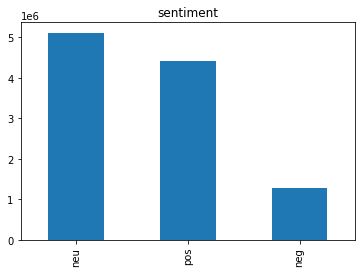

In [ ]:
dtt.sentiment.value_counts().plot(kind='bar',title='sentiment')
plt.show()

In [ ]:
# dtt[dtt.sentiment=='neg'].to_csv('/content/drive/MyDrive/Factiva/NLTK label/neg_label.csv', index=False)
# dtt[dtt.sentiment=='pos'].to_csv('/content/drive/MyDrive/Factiva/NLTK label/pos_label.csv', index=False)
# dtt[dtt.sentiment=='neu'].to_csv('/content/drive/MyDrive/Factiva/NLTK label/neu_label.csv', index=False)

# Logistic model with 3 categories

In [ ]:
def punc_clean(text):
    a=[w for w in text if w not in st.punctuation]
    return ''.join(a)

def remove_stopword(text):
    stopword=nltk.corpus.stopwords.words('english')
    stopword.remove('not')
    a=[w for w in nltk.word_tokenize(text) if w not in stopword]
    return ' '.join(a)

def clean_word(text):
    text = str(text)
    text = punc_clean(text)
    text = remove_stopword(text)
    text = re.sub('\d','',text)
    text = re.sub(r'\s+',' ', text)
    text = text.strip()
    return text

In [ ]:
# 3 categories
df = pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/pos_label.csv').append(pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/neg_label.csv'))
df = df.append(pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/neu_label.csv'))
df

,sent,sentiment
0,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand...",pos
1,"Olivia Newton, Director of Category Management...",pos
2,The WiAC organization is dedicated to the adva...,pos
3,"""I'm tremendously honored to represent both Wo...",pos
4,"""I believe strongly in the community's mission...",pos
...,...,...
5112435,"Therefore, actual performance and results may ...",neu
5112436,All forward-looking statements in this release...,neu
5112437,Investors should not place undue reliance on f...,neu
5112438,"SOURCE Spartan Motors, Inc.",neu


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


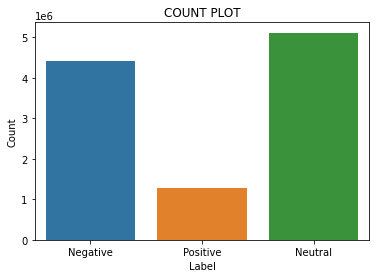

In [ ]:
# origin data
sns.countplot(df.sentiment.tolist())
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0,1,2],['Negative','Positive','Neutral'])
plt.title('COUNT PLOT')
plt.show()

In [ ]:
df['sent'] = df.sent.apply(clean_word)
df

,sent,sentiment
0,NEW YORK April PRNewswire Standard Motor Produ...,pos
1,Olivia Newton Director Category Management Cus...,pos
2,The WiAC organization dedicated advancement ed...,pos
3,Im tremendously honored represent Women Auto C...,pos
4,I believe strongly communitys mission I excite...,pos
...,...,...
5112435,Therefore actual performance results may mater...,neu
5112436,All forwardlooking statements release qualifie...,neu
5112437,Investors not place undue reliance forwardlook...,neu
5112438,SOURCE Spartan Motors Inc,neu


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.sent, df.sentiment,random_state=2, stratify=df.sentiment, test_size=0.3)

In [ ]:
# 3 categories
dff = pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/pos_label.csv').append(pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/neg_label.csv'))
dff = dff.append(pd.read_csv('/content/drive/MyDrive/Factiva/NLTK label/neu_label.csv'))
dff

,sent,sentiment
0,"NEW YORK, April 17, 2020 /PRNewswire/ -- Stand...",pos
1,"Olivia Newton, Director of Category Management...",pos
2,The WiAC organization is dedicated to the adva...,pos
3,"""I'm tremendously honored to represent both Wo...",pos
4,"""I believe strongly in the community's mission...",pos
...,...,...
5112435,"Therefore, actual performance and results may ...",neu
5112436,All forward-looking statements in this release...,neu
5112437,Investors should not place undue reliance on f...,neu
5112438,"SOURCE Spartan Motors, Inc.",neu


In [ ]:
dff['sent'] = dff.sent.apply(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dff.sent, dff.sentiment,random_state=2, stratify=dff.sentiment, test_size=0.3)

In [ ]:
# best model
TF = TfidfVectorizer()
logis = LogisticRegression(solver='sag', max_iter=500)
pipe = Pipeline([('tfidf',TF),
                  ('logistic',logis)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy :', accuracy_score(y_test,y_pred))
print('Classification Report :\n', classification_report(y_test,y_pred))
print('Confusion Matrix :\n', confusion_matrix(y_test,y_pred))

Accuracy : 0.9763644732148885
Classification Report :
               precision    recall  f1-score   support

         neg       0.94      0.91      0.92    382742
         neu       0.99      0.99      0.99   1533732
         pos       0.97      0.98      0.98   1327287

    accuracy                           0.98   3243761
   macro avg       0.97      0.96      0.96   3243761
weighted avg       0.98      0.98      0.98   3243761

Confusion Matrix :
 [[ 349156    7964   25622]
 [   5892 1515335   12505]
 [  18005    6680 1302602]]


In [ ]:
# pickle.dump(pipe, open('3class_LR_model_97acc_stop.sav', 'wb'))

In [ ]:
pickle.dump(pipe, open('3class_LR_model_96acc_stop.sav', 'wb'))